# BigEarthNet model validation
We test the model using the weights learned on a large subset of the BigEarthNetv2 dataset and a small number of images and masks examples to check whether the model worked properly.

In [ ]:
#from scripts.bigearthnetv2_data_preparation import *

In [6]:
%run -i lib/bigearthnetv2_lib.py

In [8]:
print("NumPy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)
print("Matplotlib version: %s"%matplotlib.__version__)
print("Rasterio version: %s"%rasterio.__version__)
print('Tensorflow version: {:s}'.format(tensorflow.__version__))
print('Keras version. {}'.format(keras.__version__))

NumPy version: 1.26.4
GDAL version: 3.10.2
Matplotlib version: 3.8.4
Rasterio version: 1.4.3
Tensorflow version: 2.19.0
Keras version. 3.10.0


## Preparing the sample pairs of images and masks
We unzip the sample pairs of PNG images and masks.  

In [22]:
BIGEARTHNETv2_DIR = 'data'

In [24]:
sample_pairs_zip = BIGEARTHNETv2_DIR + '/ben_prepared_sample.zip'
target_sample_dir = BIGEARTHNETv2_DIR + '/png_sample_pairs/'

In [25]:
unzip_pngs(sample_pairs_zip, target_sample_dir)

In [26]:
img_dir = pathlib.Path(target_sample_dir + '/images')
img_file_list = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".png")]
img_paths = sorted(img_file_list)
print('Number of images: {:d}'.format(len(img_paths)))

Number of images: 64


In [27]:
msk_dir = pathlib.Path(target_sample_dir + '/masks')
msk_file_list = [os.path.join(msk_dir, fname) for fname in os.listdir(msk_dir) if fname.endswith(".png")]
msk_paths = sorted(msk_file_list)
print('Number of masks: {:d}'.format(len(msk_paths)))

Number of masks: 64


In [34]:
img_array = get_image_array(img_paths[0])
img_array.dtype, img_array.shape

(dtype('uint8'), (3, 120, 120))

In [35]:
img_array_perm = np.moveaxis(img_array, 0, 2)
img_array_perm.shape

(120, 120, 3)

In [41]:
msk_array = get_image_array(msk_paths[0])
msk_array.dtype, msk_array.shape

(dtype('uint16'), (120, 120))

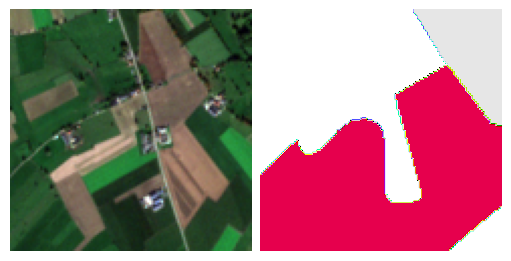

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 5), layout='constrained')
corine2018_color_map = ListedColormap(corine_color_map())
img = np.array(Image.open(img_paths[0]))
msk = np.array(Image.open(msk_paths[0]))
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].imshow(img)
ax[1].imshow(msk, cmap=corine2018_color_map)

## Loading the images into a batch 
We prepare a batch for the trained model to predict the masks

In [64]:
img_size = msk_array.shape
num_train_imgs = 32 #len(img_paths)
batch_imgs = np.zeros((num_train_imgs,) + img_size + (3,), dtype='uint8')
batch_imgs.shape

(32, 120, 120, 3)

In [65]:
from tensorflow.keras.utils import array_to_img, load_img, img_to_array
for i in range(num_train_imgs):
    batch_imgs[i] = img_to_array(load_img(img_paths[i], target_size=img_size))

In [66]:
batch_imgs.shape

(32, 120, 120, 3)

## Predicting the masks
We use the batch of images to predict the masks

In [ ]:
best_model = keras.models.load_model("data/bigearthnet_v2.keras")

In [74]:
batch_imgs[0].shape

(120, 120, 3)

In [75]:
predicted_masks_batch = best_model.predict(batch_imgs[0])

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(32, 120, 3)

## Comparing the predicted masks and the ground truth